# SETS

A counterfactual explanation, originally introduced to machine learning by [1], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Shapelet-based Temporal Association Rule Mining for Multivariate Time Series Classification developed by Bahri et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of a shapelet algorithm. Hereby they extract the most prominent class shapelets using an adaption of the shapelet transform algorithm of [2] implemented in sktime. The algorithm is adapted to multivariate timeseries analysis, treating each dimension as a univariate timeseries and information gain. The algorithm imputes the shapelets based on prior observed occcurences and shapelet quality. If a single shapelet does not cause a counterfactual prediction, more perturbations in other dimensions or other parts of the timeseries are performed. 


<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/SETS_CF.png" alt="Visualization of SETS_CF" style="width: 800px;" />



Visualization of SETS from the original paper [1]; The code in TSInterpret is based on the authors <a href='https://github.com/omarbahri/SETS'>implementation </a>.

[1] Omar Bahri and Soukaina Filali Boubrahimi and Shah Muhammad Hamdi.Shapelet-Based Counterfactual Explanations for Multivariate Time Series. 2022 ACM SIGKDD Workshop on Mining and Learning from Time Series. arXiv:2208.10462 URL:https://arxiv.org/abs/2208.10462 (visited on 2023-12-04)


[2] Hills, Jon and Lines, Jason and Baranauskas, Edgaras and Mapp, James and Bagnall, Anthony. Classification of time series by shapelet transformation. Data Mining and Knowledge Discovery. Harv. JL & Tech. 31 (2017): 841.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from tslearn.datasets import UCR_UEA_datasets
import warnings
import tensorflow.keras as keras

warnings.filterwarnings("ignore") 

2024-10-30 12:56:34.304439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 12:56:34.340247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 12:56:34.340275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 12:56:34.340304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 12:56:34.347020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

## Load Data and Model
- Load Data and reshape the data to fit a 1D-Conv Convolutional Neural Network (CNN). Note that the input for a 1D-Conv CNN hat the shape (batch, timesteps, features).
- Load Model with Pretrained Weigths. 

In [2]:
data = UCR_UEA_datasets().load_dataset("ECG200")

In [3]:
model = keras.models.load_model("../../ClassificationModels/models/ECG200/best_model_ecg200_fcn_wang_ep200.hdf5")

2024-10-30 12:56:36.317902: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-30 12:56:36.317927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: jacqueline-ThinkPad-P53
2024-10-30 12:56:36.317934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: jacqueline-ThinkPad-P53
2024-10-30 12:56:36.318002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-10-30 12:56:36.318024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-10-30 12:56:36.318030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading & Initialization

SETS works on all models returning a probability function. The Initialization takes the following arguments:

    `model`: The model to be explaines.
    `data`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.
    `min_shapelet_len` : Value for min length of extracted shapelets 
    `max_shapelet_len`: Value for max length of extracted shapelets
    `time_contract_in_mins_per_dim` : Max time for shapelet extraction per dimension
    `initial_num_shapelets_per_case` : Initial number of shapelets per case.

### For Univariate ECG200 Case

In [4]:
%load_ext autoreload
%autoreload 2

from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF

train_x, train_y, test_x, test_y = data

# Note: this is for demonstration purposes, time contract per minutes should be adjusted for better results! 
exp_model= SETSCF(model,
                  (train_x, train_y),
                  backend='TF',
                  mode='time',  
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False)


96
TRAINSHAPE (100, 1, 96)
Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


### 3. Call the fit method.

This method is optional! If shapelets are already exctracted, please specify here the occlusion threshhold and if shapelets belonging to multiple classes should be retained. 
This method is called by default if the explain_model is fitted. 


In [5]:
exp_model.fit(occlusion_threshhold=1e-1,remove_multiclass_shapelets=True)

Fit function to prune shapelets with occlusion threshhold of 0.1 and remove shapelets belonging to more than one class set to True
Shapelet by index per class and dimension: {0: [[1, 4, 5, 7, 8, 10, 11, 12, 13, 18, 20, 22, 28]], 1: [[0, 2, 3, 6, 9, 14, 15, 16, 17, 19, 21, 23, 24, 25, 26, 27]]}



### 4. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained

In [6]:
ts = 5
test_y[ts]
cf_explanation, label = exp_model.explain(test_x[ts], target = None)

TARGETS [0, 1]
(1, 96)
(1, 96)
BEFOR
(1, 96)
(1, 1, 96)
1/1 [==============================] - 0s 126ms/step
[[3.1818963e-05 9.9996817e-01]]
1/1 [==============================] - 0s 15ms/step
orig_c 1
1/1 [==============================] - 0s 15ms/step
cf dim [ 2.09426370e-01  1.27332860e+00  2.82431420e+00  3.59230590e+00
  2.22366160e+00  2.30630748e-01 -3.58492435e-01 -4.08798751e-02
  1.67377200e-01 -2.17760835e-01 -1.13907275e+00 -1.11832870e-01
 -4.63722430e-01 -6.51699997e-01 -8.98853361e-01 -2.88729838e-01
  5.70374060e-01  2.15877466e-01  1.04694706e-02 -2.60206694e-01
 -2.43256289e-01 -5.90708843e-01 -1.49479540e+00 -1.41248530e+00
 -1.19165230e+00 -1.53980400e+00 -1.62443230e+00 -1.75137560e+00
 -1.76312040e+00 -1.85480430e+00 -1.92741270e+00 -1.90014240e+00
 -1.94878490e+00 -1.66078850e+00 -1.56231660e+00 -1.25276290e+00
 -9.09501830e-01 -7.33620370e-01 -1.04992640e-01  8.00453670e-02
  2.41404000e-01  4.89304280e-01  6.48374510e-01  8.78162280e-01
  8.07055360e-01  1.0020

### 4. Visualization

All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given.


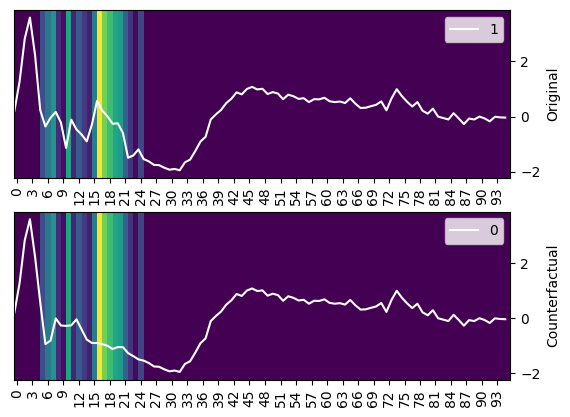

In [7]:
exp_model.plot(
        cf_explanation,
        np.argmax(model(data[2])[ts]),
        test_x[ts],
        label,
        vis_change=True,
        all_in_one=False,
        save_fig=None,
        figsize=(6.4, 4.8))

### Multivariate Case

In [8]:
data = UCR_UEA_datasets().load_dataset("BasicMotions")
model = keras.models.load_model("../../ClassificationModels/models/BasicMotions/best_model_bm_fcn_wang_ep200.hdf5")
train_x,train_y,test_x,test_y = data

In [9]:
exp_model= SETSCF(model,
                  (train_x,train_y),
                  backend='TF',
                  mode='time',         
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False)


100
TRAINSHAPE (40, 6, 100)
Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


In [10]:
exp_model.fit(occlusion_threshhold=1e-1,remove_multiclass_shapelets=True)

Fit function to prune shapelets with occlusion threshhold of 0.1 and remove shapelets belonging to more than one class set to True
Shapelet by index per class and dimension: {0: [[0, 1, 21, 22, 27, 28, 29, 34, 35, 36, 37, 38, 39, 42, 43, 44, 48, 50, 51, 52, 54, 55, 63, 72, 79], [0, 1, 2, 3, 4, 34, 36, 37, 38, 39, 40, 42, 43, 46, 47, 52, 54, 56, 61, 62, 68, 74, 75], [0, 6, 10, 11, 19, 20, 22, 24, 27, 28, 37, 40, 41, 44, 47, 52, 54, 62, 67, 68, 72, 73], [15, 16, 24, 28, 29, 30, 31, 32, 36, 39, 40, 42, 44, 51, 53, 59, 66, 69, 70, 71, 73], [3, 9, 14, 20, 25, 26, 27, 28, 29, 34, 44, 53, 54, 55, 57, 58, 63, 64, 72, 73], [0, 1, 2, 3, 4, 5, 6, 7, 24, 25, 26, 33, 36, 37, 38, 39, 44, 46, 49, 50, 53, 60, 66]], 1: [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 30, 66], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 41, 64], [15, 25, 29, 30, 31, 34, 38, 48, 51, 53, 55, 56, 57, 58, 61, 69, 70, 74, 75, 76], [0, 2, 3, 4, 7, 8, 10, 12, 19, 20, 23, 25, 34, 37, 43, 57], [0, 4, 5, 10, 11, 12, 

In [11]:
ts = 12
cf_explanation, label = exp_model.explain(test_x[ts], target = None)

TARGETS [0, 1, 2, 3]
(6, 100)
(6, 100)
BEFOR
(6, 100)
(1, 6, 100)
1/1 [==============================] - 0s 90ms/step
[[7.4000991e-06 9.9994290e-01 4.7631842e-05 2.0043562e-06]]
1/1 [==============================] - 0s 17ms/step
orig_c 1
1/1 [==============================] - 0s 16ms/step
cf dim [ 19.107834    14.52228284  17.24931022  18.4029233   18.4029233
  -7.5199301  -11.463355     1.05306348  18.76972074  14.13611811
  11.69760162  14.74572255  15.10067874  -1.74829457  -9.68762009
  -6.14155028  15.6270225   19.01062786  19.01062786  13.873507
  -7.305471   -17.519981    -9.903713    14.523422    15.415318
   8.282308     6.455426    13.69737633  13.14445512  14.08314538
  14.08314538  14.43100368 -14.454145   -11.66996735  10.52071178
  14.682182    11.91915192  11.91915192  11.74248475  13.79230386
   3.52971443 -12.79238755 -13.921055   -12.77457801 -14.989109
 -14.02470881 -11.78908371  -8.21715618  -1.55982204   3.18394357
  15.712776     4.93123514  -7.62530926  -8.17508

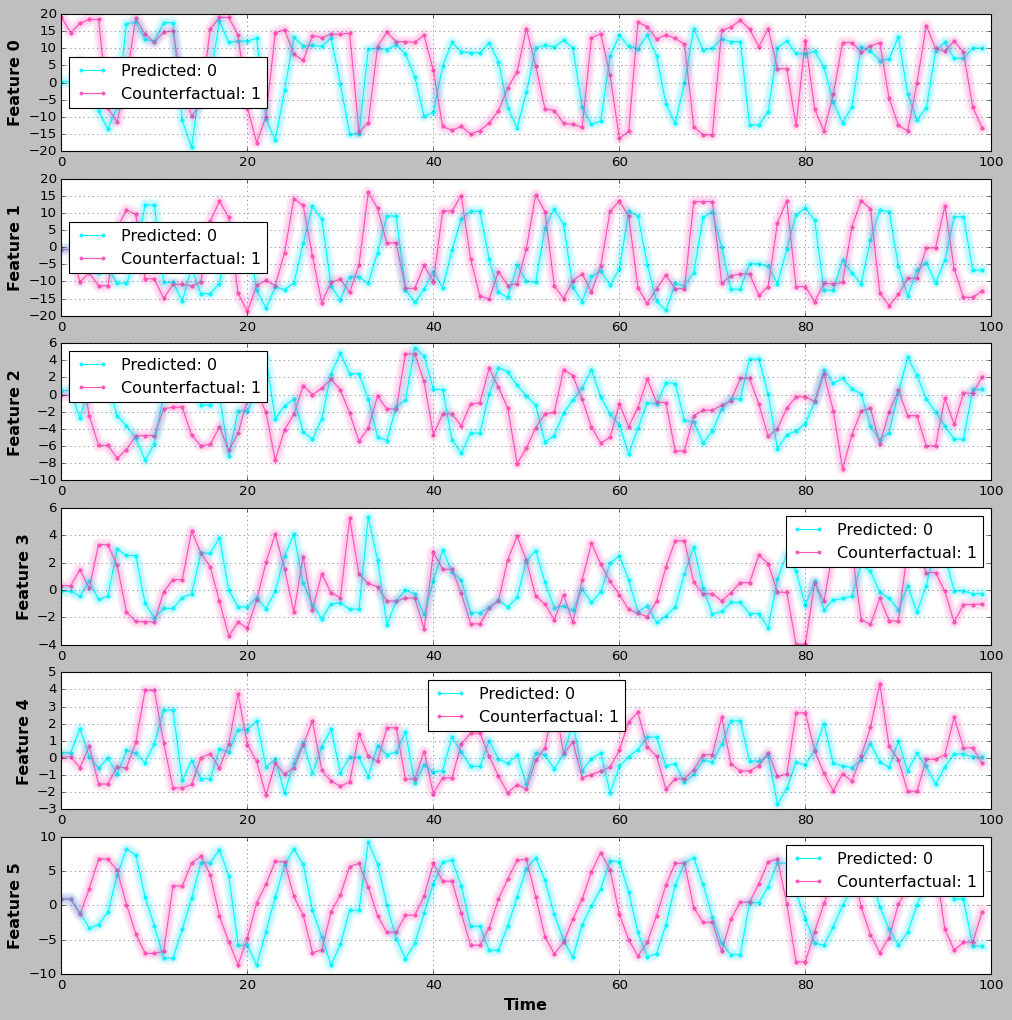

In [12]:
#item, org_label, exp, cf_label, save_fig=None, figsize=(6.4, 4.8)
exp_model.plot_in_one(test_x[10],0,np.swapaxes(cf_explanation,0,1),1,figsize=(15,15))